This is an implementation of the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) for Python code prediction from text input


![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer1.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/END_CAPSTONE'
!ls

/content/drive/.shortcut-targets-by-id/1gNidNMYrNUAjAnXKf6tD6r_vGGXKBviM/END_CAPSTONE
'Copy of Capstone-Python Prediction.ipynb'
 dataset
 exercises
 glove_dataset_preprocessing.ipynb
 glove_embs_post_processing.ipynb
 glove_embs_training_trails_test1.ipynb
 python-model.pt
 readme.gdoc
 temp
 trainsformer_train_srccode_trials_test1.ipynb
 trainsformer_train_srccode_trials_test2.ipynb
 word2vec_embs_training_trails_test1.ipynb


In [ ]:
# !pip install -U torchtext==0.8.0
# !pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# from torchtext.datasets import Multi30k
# from torchtext.data import Field, BucketIterator
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import pickle
from tqdm import tqdm as tqdm
import pygments
from pygments.lexers import PythonLexer

Do you need to use glove trained embedding if the use case is limited?

In [ ]:
# with open('./dataset/small_dataset/glove_trained_models/embeddings/pygments_glove_embedding.pkl' , 'rb') as f:
#   embedding_corpus = pickle.load(f)
# print('shape of the embedding_corpus is ', len(embedding_corpus))
 
with open('./dataset/small_dataset/transformer_dataset/clean_python_dataset_final.pkl' , 'rb') as f:
  python_dataset = pickle.load(f)
print('length of the dataset is ', len(python_dataset))

length of the dataset is  3399


In [ ]:
rn= np.random.choice(len(python_dataset),1).item()
python_dataset[rn]
print(rn,':',python_dataset[rn]['obj'])
print(python_dataset[rn]['code'])
python_dataset[rn]['code']

# 3153

1759 : Write a function to Subtracts two lists element wise
def sub_listelements(l1:list, l2:list):
    return [i-j for i, j in zip(l1,l2)]



'def sub_listelements(l1:list, l2:list):\n    return [i-j for i, j in zip(l1,l2)]\n'

In [ ]:
# rn= 3153
# python_dataset[rn]
# print(rn,':',python_dataset[rn]['obj'])
# print(python_dataset[rn]['code'])
# len(python_dataset[rn]['code'].strip('# '))

# del python_dataset[rn]

# print('deleting...........')
# python_dataset[rn]

In [ ]:
lexer = PythonLexer()
tokens_test = lexer.get_tokens(python_dataset[rn]['code'])
print(python_dataset[rn]['code'])
# x = [i for i in tokens_test]

toks = [(str(i[0]), str(i[0]).split('.')[-1],i[1])  for i in tokens_test]

# toks

def sub_listelements(l1:list, l2:list):
    return [i-j for i, j in zip(l1,l2)]



In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# !python -m spacy download en

In [ ]:
spacy_en = spacy.load('en')

add token type along with token emb and positon embedding

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]


def tokenize_src_code_pygments(text):
  """tokenizer for python source code. Given a tuple of token type and token. Using only token here"""
  tokens_org = lexer.get_tokens(text)
  tokens_filtered = [i[1] for i in tokens_org if i[0] != pygments.token.Comment.Single]
  return tokens_filtered


def tokenize_token_type(snipp):
  tokens_obj = lexer.get_tokens(snipp)
  tok_type = [(str(i[0]).split('.')[-1])  for i in tokens_obj if i[0] != pygments.token.Comment.Single]
  return tok_type

In [ ]:
# CH,
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)


TRG = Field(tokenize = tokenize_src_code_pygments, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)

TRG_TOK = Field(tokenize = tokenize_token_type, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)


fields = [('src', SRC),('trg',TRG),('trg_tok', TRG_TOK)]

In [ ]:
example = [data.Example.fromlist([python_dataset[i]['obj'],python_dataset[i]['code'],python_dataset[i]['code']], fields) for i in tqdm(range(len(python_dataset)))];

100%|██████████| 3399/3399 [00:04<00:00, 699.89it/s]


whats this for? how cna you truncate code?

In [ ]:
# print(len(example))
DECODER_MAX_LENGTH = 1024
# for idx, i in enumerate(example):
#       # print(idx,vars(i) ) 
#       # break
#   if len(i.trg) > 768:
#       print(idx, len(i.trg))
#       del example[idx]
# print(len(example))


# for idx, i in enumerate(example):
#   if len(i.trg) > 500:
#     print(idx,len(i.trg)) 
#     # break

# # del example[568]

In [ ]:

for idx,i in enumerate(example):
    if len(i.trg) > 768:
      # print(i.trg)
      # print('\n')
      # print(i.trg[:767])
        i.trg = i.trg[:767]
        i.trg_tok = i.trg_tok[:767]
        
max_len = 0
avg_len = 0
count_len = 0
for i in example:
    if len(i.trg)>max_len:
        max_len = len(i.trg)
    if len(i.trg)>512:
        count_len+=1
    avg_len += len(i.trg)
avg_len = avg_len/len(example)
print(max_len, avg_len, count_len)

767 79.83259782288908 31


some example has dashed line in obj

19th example had number in obj

sample 663 or 87 has sample number and function description in ''' '''

In [ ]:
# index = random.randint(0,1000)
index=865
print(f'Index:{index}',example[index].src,'\n', len(example[index].trg), example[index].trg,'\n',len(example[index].trg_tok), example[index].trg_tok)
print(''.join(example[index].trg))

Index:865 ['write', 'a', 'python', 'function', 'that', 'given', 'a', 'string', 'and', 'an', 'integer', 'number', 'n', ',', 'remove', 'characters', 'from', 'a', 'string', 'starting', 'from', 'zero', 'up', 'to', 'n', 'and', 'return', 'a', 'new', 'string'] 
 20 ['def', ' ', 'removeChars', '(', 'str', ',', ' ', 'n', ')', ':', '\n', '    ', 'return', ' ', 'str', '[', 'n', ':', ']', '\n'] 
 20 ['Keyword', 'Text', 'Function', 'Punctuation', 'Builtin', 'Punctuation', 'Text', 'Name', 'Punctuation', 'Punctuation', 'Text', 'Text', 'Keyword', 'Text', 'Builtin', 'Punctuation', 'Name', 'Punctuation', 'Punctuation', 'Text']
def removeChars(str, n):
    return str[n:]



In [ ]:
# creating splits
pythonDataset = data.Dataset(example, fields)
(train_data, valid_data, test_data) = pythonDataset.split(split_ratio=[0.84, 0.01,0.15], random_state=random.seed(SEED))

print('Total training samples --> {}'.format(len(train_data)))
print('Total validation samples --> {}'.format(len(valid_data)))
print('Total test samples --> {}'.format(len(test_data)))

Total training samples --> 2855
Total validation samples --> 510
Total test samples --> 34


In [ ]:
# index = random.randint(0,500)
# vars(test_data.examples[index])

Do space to tabs here

Change min freq to 2

# why not build vacb from enture dataset????

In [ ]:

# TRG.build_vocab(pythonDataset, min_freq = 1)
# len(TRG.vocab)

In [ ]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)
TRG_TOK.build_vocab(train_data, min_freq = 1)
len(TRG.vocab)

5133

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x: len(x.src),
     sort_within_batch=True,
     device = device)

In [ ]:
# print('checking out one batch')
# x = next(iter(train_iterator))
# print(x.src.shape,x.trg.shape)

Correlation matrix concept is used to get contextualised embedding. But Why? We donot use recurrence in this model. How else will you encode context information? Create representations that combine relavent information from all words in the sentence. Relevence obtained from the correlation matrix. This is essentially the contextualised embedding in the figure below. 

### Concept of Query, Key and Value

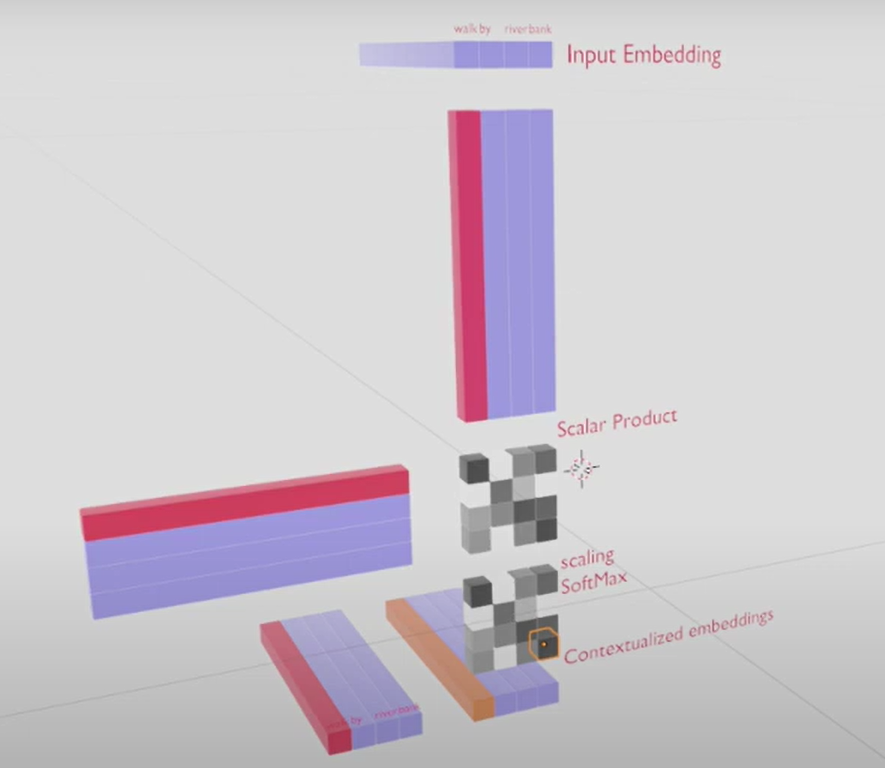

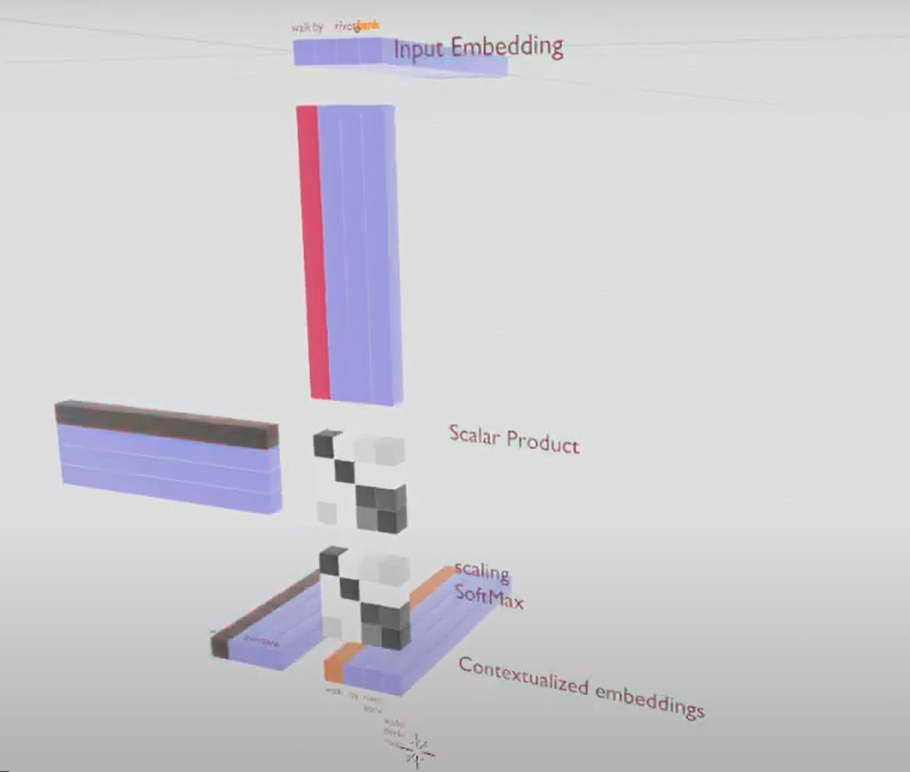

We use query,value and keys setting to obtain good representation of data from the one hot-encoded input. In the grand scheme of things, it is trying to use the NN to compartmentalize information representation within the embedding space.
Q-FC, K-FC, V-FC are trying to represent input embedding in a form that best describes the data pattern.

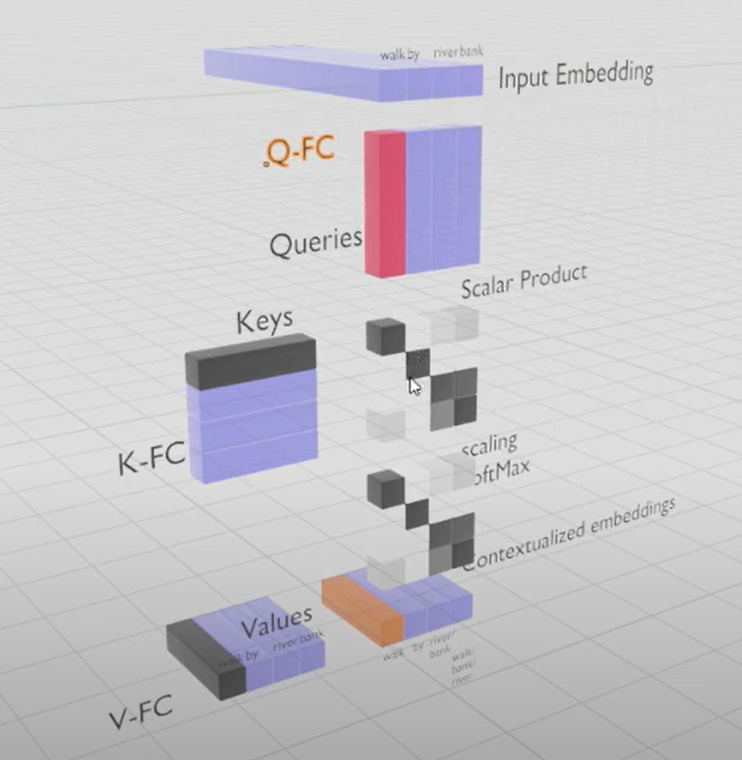

 An intuition could be that the Q-FC is trying to represent embedding with respect to object type, K-Fc with respect to position etc. For example, the FC layer is trying to find positions in the "bank" embedding that represent different types of "bank"(river "bank", ATM "bank", "bank on"). Maybe the first block is learning bank related concepts, second block maybe learning emotion related, third block maybe number of objects and the fourth maybe learning something else. This is the "multi-head". 

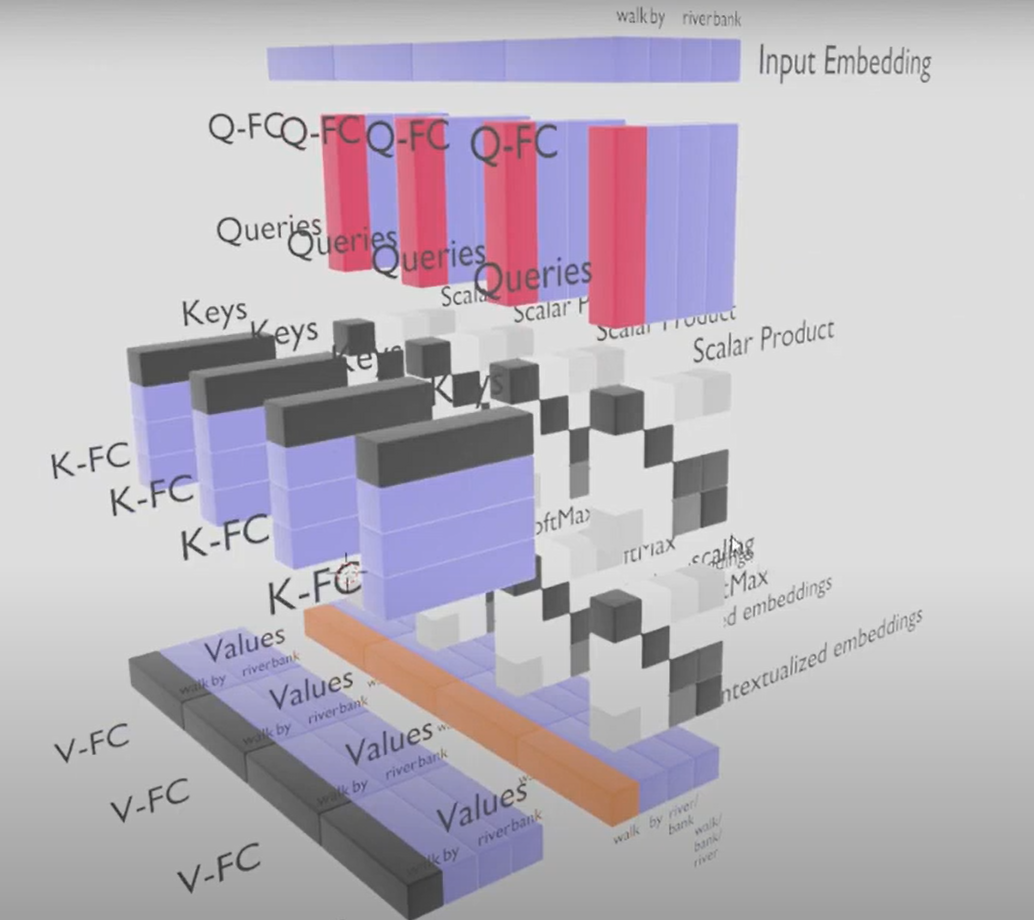

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len] This is to avoid sending <pad> into attention block
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        # Intuition: say concept A and A' are similar in nature but far apart. This is done to sort the embedding values so that related embedding positions are flocked together in a block
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        # -1 or q/k/v len       
        # this permute is to facilitate transpose and mattrix multiplication to get the correlation. Check above figure
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        # print('why fail here',Q.shape, K.permute(0, 1, 3, 2).shape, self.scale.shape)       
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        # Note that the word "contiguous" is bit misleading because its not that the content of tensor is spread out around disconnected blocks of memory. Here bytes are still allocated in one block of memory but the order of the elements is different!
        # When you call contiguous(), it actually makes a copy of tensor so the order of elements would be same as if tensor of same shape created from scratch.
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [ ]:
# CH go back to add token_type in data and at all function calls-2
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 tok_dim,
                 max_length = DECODER_MAX_LENGTH):
        super().__init__()

        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim + tok_dim, hid_dim)
        # add token type embedding 
        self.tok_type_embedding = nn.Embedding(tok_dim,10)
        self.tok_fc = nn.Linear(hid_dim + 10, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.toktype_fc = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        # print('fh',hid_dim.shape, torch.sqrt(torch.FloatTensor([hid_dim])).shape)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask, tok_type):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
        # print('bp',self.tok_embedding(trg).shape)    
        # + (self.tok_type_embedding(tok_type) * self.scale)

        # tgt_combined = self.tok_fc(torch.cat([self.tok_embedding(trg), ],dim = -1))* self.scale
        # trg = self.dropout(tgt_combined + self.pos_embedding(pos) )
        # trg = torch.cat([trg, tok_type], dim =-1)
        # print('fu', trg.shape, tok_type.shape, self.tok_embedding(trg).shape, self.pos_embedding(pos).shape )
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos) )

        # token_info = torch.cat([trg, self.tok_type_embedding(tok_type)], dim =-1)
        # print('lastlife',token_info.shape,self.tok_fc(token_info) )
        # trg = self.tok_fc(token_info)
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        tokenType = self.toktype_fc(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention, tokenType

In [ ]:
# # import torch
# a=torch.rand(3,4,6).to(torch.int64)
# b=torch.rand(3,4,9).to(torch.int64)
# f=nn.Embedding(15, 10)

# print(a.shape,b.shape)
# cT=torch.cat([a, b], dim =-1)
# print(cT.shape)
# f(cT).shape

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        # input to attention layer takes format (query, key, value). Encoder input is taken as key and values. target predicted so far is 
        # taken as query. Given the target(predicted so far) as query, match it to keys and get the appropriate value. Keys and values hold
        # information about the input. Given the input as the database, predict the value as per query(just like youtube search)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        # since we donot have a recurrence model, we send the entire ground truth but one unmasked word at a time. Backprop happens for each sample
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg, trg_tok):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention, tokentype = self.decoder(trg, enc_src, trg_mask, src_mask, trg_tok)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention,tokentype

In [ ]:
len(SRC.vocab)

1841

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
TOK_TYPE_DIM = len(TRG_TOK.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 256
DEC_PF_DIM = 256
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              TOK_TYPE_DIM)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,376,444 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

check pos and tok embedding concept

In [ ]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(1841, 128)
    (pos_embedding): Embedding(100, 128)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=128, out_features=256, bias=True)
          (fc_2): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
     

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [ ]:
train_loss_arr=[]
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        tok = batch.trg_tok
        optimizer.zero_grad()
        
        output, _ , tokenType= model(src, trg[:,:-1],tok[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        tokenType = tokenType.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        tok = tok[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = (criterion(output, trg) + criterion(tokenType, tok))
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    train_loss_arr.append(epoch_loss)
        
    return epoch_loss / len(iterator)

In [ ]:
val_loss_arr=[]
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            tok = batch.trg_tok

            output, _ ,tokentype = model(src, trg[:,:-1],tok[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            tokentype = tokentype.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            tok = tok[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            loss = (criterion(output, trg) + criterion(tokentype, tok))
            #  + criterion(tokentype, tok))
            # loss = criterion(output, trg)

            epoch_loss += loss.item()
    val_loss_arr.append(epoch_loss)    
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 100
CLIP = 1
CUDA_LAUNCH_BLOCKING=1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'python-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 14s
	Train Loss: 9.518 | Train PPL: 13605.817
	 Val. Loss: 5.458 |  Val. PPL: 234.727
Epoch: 02 | Time: 0m 13s
	Train Loss: 4.737 | Train PPL: 114.053
	 Val. Loss: 4.191 |  Val. PPL:  66.085
Epoch: 03 | Time: 0m 13s
	Train Loss: 4.026 | Train PPL:  56.045
	 Val. Loss: 3.851 |  Val. PPL:  47.031
Epoch: 04 | Time: 0m 13s
	Train Loss: 3.751 | Train PPL:  42.545
	 Val. Loss: 3.659 |  Val. PPL:  38.822
Epoch: 05 | Time: 0m 13s
	Train Loss: 3.552 | Train PPL:  34.866
	 Val. Loss: 3.517 |  Val. PPL:  33.689
Epoch: 06 | Time: 0m 13s
	Train Loss: 3.393 | Train PPL:  29.746
	 Val. Loss: 3.396 |  Val. PPL:  29.848
Epoch: 07 | Time: 0m 14s
	Train Loss: 3.272 | Train PPL:  26.370
	 Val. Loss: 3.288 |  Val. PPL:  26.785
Epoch: 08 | Time: 0m 13s
	Train Loss: 3.155 | Train PPL:  23.448
	 Val. Loss: 3.210 |  Val. PPL:  24.782
Epoch: 09 | Time: 0m 14s
	Train Loss: 3.042 | Train PPL:  20.949
	 Val. Loss: 3.131 |  Val. PPL:  22.887
Epoch: 10 | Time: 0m 13s
	Train Loss: 2.939 | Train P

Text(0, 0.5, 'some numbers')

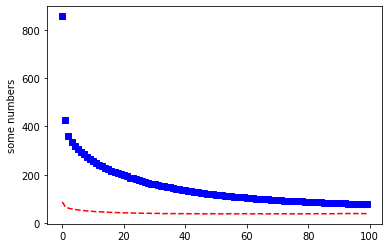

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plt.plot(val_loss)
plt.plot(np.arange(len(val_loss_arr)), val_loss_arr, 'r--', np.arange(len(val_loss_arr)), train_loss_arr, 'bs')
plt.ylabel('some numbers')


In [ ]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
'Copy of Capstone-Python Prediction.ipynb'
 dataset
 exercises
 glove_dataset_preprocessing.ipynb
 glove_embs_post_processing.ipynb
 glove_embs_training_trails_test1.ipynb
 python-model.pt
 readme.gdoc
 temp
 trainsformer_train_srccode_trials_test1.ipynb
 trainsformer_train_srccode_trials_test2.ipynb
 word2vec_embs_training_trails_test1.ipynb


In [ ]:
model.load_state_dict(torch.load('python-model.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

<All keys matched successfully>

In [ ]:
#CH

def translate_sentence(sentence, src_field, trg_field, model, device, tok_type_field, max_len = DECODER_MAX_LENGTH):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    trg_tok_indexes = [tok_type_field.vocab.stoi[tok_type_field.init_token]]
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_tok_tensor = torch.LongTensor(trg_tok_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention,_ = model.decoder(trg_tensor, enc_src, trg_mask, src_mask, trg_tok_tensor )
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)
        # if eos encountered before maxlen is reached
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
for test in test_data:
  # print(vars(test))
  print('*'*10 + 'Prompt' +'*'*10)
  print(' '.join(test.src))
  print('*'*10 + 'Target Code' +'*'*10)
  print(''.join(test.trg))
  print('*'*10 + 'Predicted Code' +'*'*10)
  translation, attention = translate_sentence(test.src, SRC, TRG, model, device, TRG_TOK)
  print(''.join(translation))

  print('\n \n')

**********Prompt**********
write a program to find and print if a number is a harshad number
**********Target Code**********
num = 156;
rem = sum = 0;
n = num;
while(num > 0):
    rem = num%10;
    sum = sum + rem;
    num = num//10;
if(n%sum == 0):
    print(str(n) + " is a harshad number")
else:
    print(str(n) + " is not a harshad number")

**********Predicted Code**********
def amstrong_check(n):
    a=list(map(lambda x: x*2,n))
    if(n==0):
        return True
    else:
        return False
<eos>

 

**********Prompt**********
write a python function to remove duplicate items from the list
**********Target Code**********
def remove_duplicatesinlist(lst):
    return len(lst) == len(set(lst))

**********Predicted Code**********
def remove_duplicates(dup_list: list):
    print(set(dup_list))
<eos>

 

**********Prompt**********
write a function to return the product of the roots of a quadratic equation ax**2 + bx + c = 0
**********Target Code**********
def prod_of_roots(a:float,b:f

In [ ]:
from torchtext import data
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 2000):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, TRG_TOK, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return metrics.bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

In [ ]:
example_idx = 12

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(' '.join(src))
print(''.join(trg))

write a function to return the area of a square
def cal_area_square(side):
    return side**2



In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device, TRG_TOK)

print("".join(translation))

def cal_area_square(side):
    return side**2
<eos>


In [ ]:
def display_attention(sentence, translation, attention, n_heads = 4, n_rows = 2, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        # print('attn',attention.shape)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

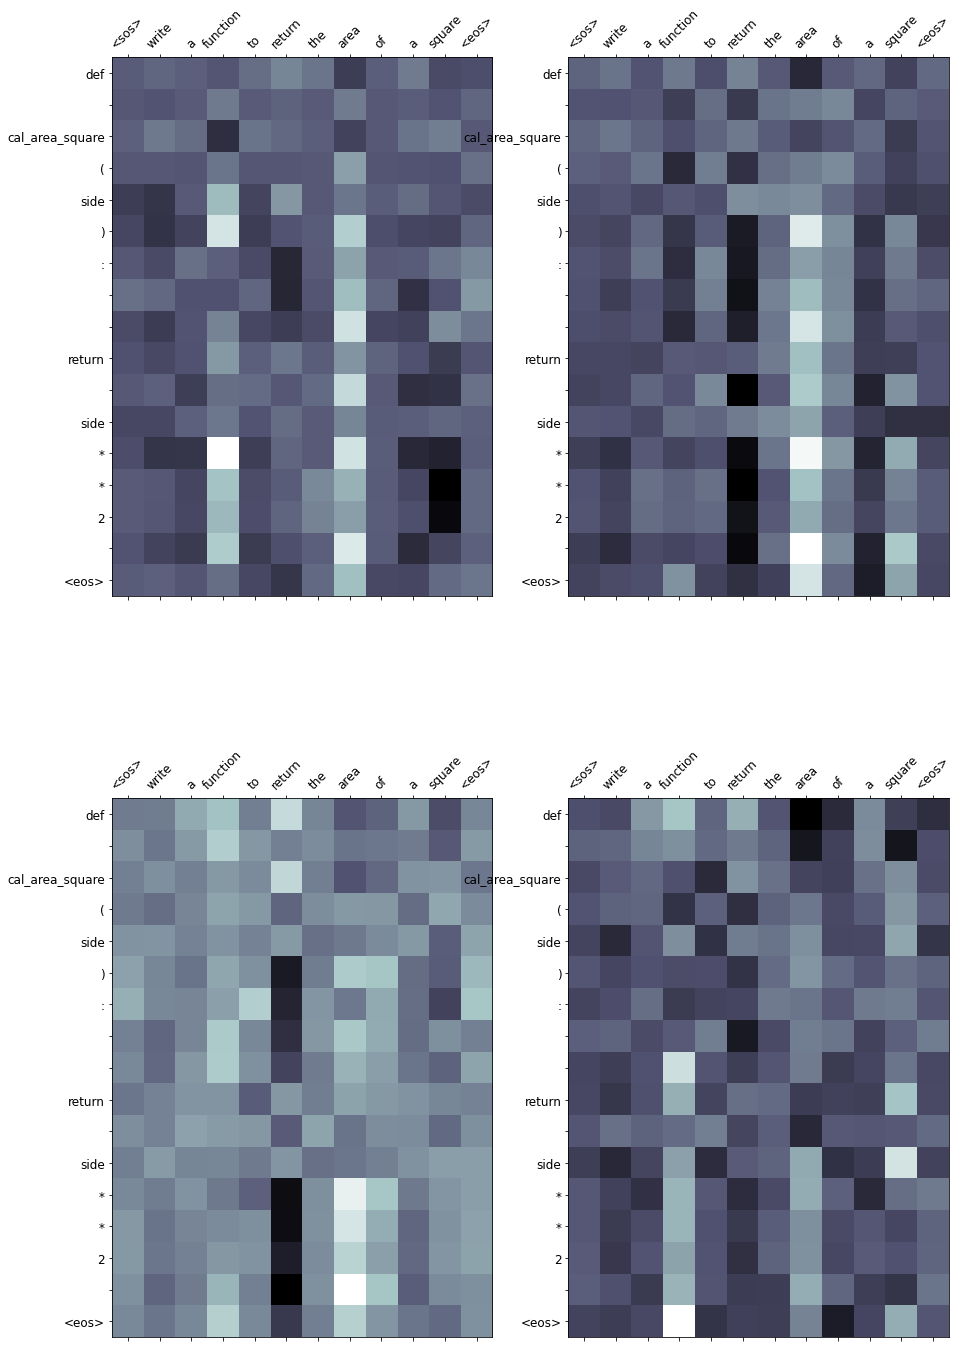

In [ ]:

display_attention(src, translation, attention)